# Importation des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sep = ','
encode= 'ISO-8859-1'
data_train = pd.read_csv("../data/train.csv", sep=sep, encoding=encode)
data_test = pd.read_csv("../data/test.csv", sep=sep, encoding=encode)
data_attributes = pd.read_csv(
    "../data/attributes.csv", sep=sep, encoding=encode)
data_description = pd.read_csv(
    "../data/product_descriptions.csv", sep=sep, encoding=encode)

del data_train['id']
del data_test['id']

# Parcours des données

In [2]:
print(f"testing data has {data_test.isnull().values.sum()} null values:")
print(f"attribute data has {data_attributes.isnull().values.sum()} null values:")
print(f"description data has {data_description.isnull().values.sum()} null values:")

testing data has 0 null values:
attribute data has 2594 null values:
description data has 0 null values:


## Data Train

In [3]:
data_train.info()
print(f"\nNombre de valeur null : {data_train.isnull().values.sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_uid    74067 non-null  int64  
 1   product_title  74067 non-null  object 
 2   search_term    74067 non-null  object 
 3   relevance      74067 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB

Nombre de valeur null : 0


In [4]:
print("Total titre produits : {} ".format(len(data_train.product_title.unique())))
print("Total recherche : {} ".format(len(data_train.search_term.unique())))
print("Total product_uid : {} ".format(len(data_train.product_uid.unique())))

Total titre produits : 53489 
Total recherche : 11795 
Total product_uid : 54667 


Remarque : on a des produit avec un *product_uid* différrent mais un titre identique

## Data description

In [5]:
data_description.info()
print(f"\nNombre de valeur null : {data_description.isnull().values.sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124428 entries, 0 to 124427
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   product_uid          124428 non-null  int64 
 1   product_description  124428 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB

Nombre de valeur null : 0


In [6]:
print("Total product_uid : {}  ".format(len(data_description.product_uid.unique())))
print("Total desciption : {} ".format(len(data_description.product_description.unique())))

Total product_uid : 124428  
Total desciption : 110128 


Remarque : certains produits ont des desciptions identiques

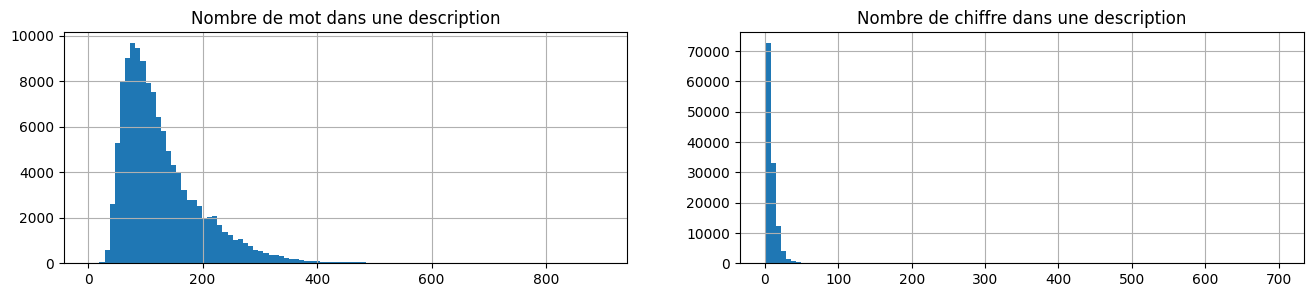

In [7]:
fig = plt.figure(figsize=(16, 3), dpi=100)
ax = plt.subplot(1, 2, 1)
ax.set_title('Nombre de mot dans une description')
(data_description.product_description.str.count('[a-zA-Z_]+')+1).hist(bins=100, ax=ax)
ax = plt.subplot(1, 2, 2)
ax.set_title('Nombre de chiffre dans une description')
(data_description.product_description.str.count('\d+')+1).hist(bins=100, ax=ax)
plt.show()

## Data attribute

In [8]:
data_attributes.info()
print(f"\nNombre de valeur null : {data_attributes.isnull().values.sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044803 entries, 0 to 2044802
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   product_uid  float64
 1   name         object 
 2   value        object 
dtypes: float64(1), object(2)
memory usage: 46.8+ MB

Nombre de valeur null : 2594


In [9]:
print("Total product_uid : {}  ".format(len(data_attributes.product_uid.unique())))

Total product_uid : 86264  


Remarque : beaucoup de produit manquant

<AxesSubplot: xlabel='relevance', ylabel='count'>

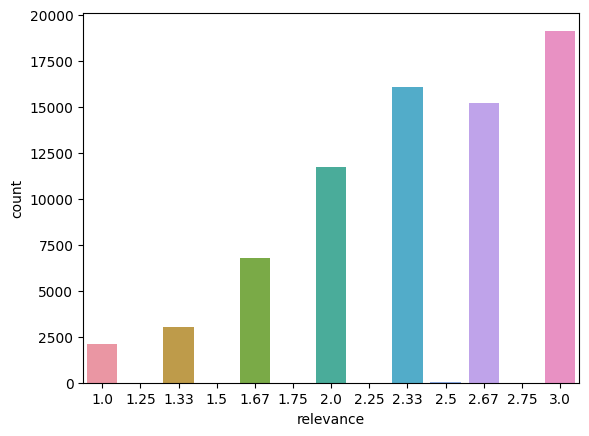

In [10]:
sns.countplot(x=data_train.relevance)

# Transformation des données

In [11]:
#data_train_test = pd.concat([data_train[['product_uid','product_title']],data_test[['product_uid','product_title']]])
#data_description_title = data_description.join(data_train_test[['product_uid','product_title']].set_index('product_uid'), on='product_uid')
#data_description_title = data_description_title.drop_duplicates(subset ='product_uid')
#data_description_title.to_csv('../data/product_descriptions_title.csv', index=False)

#data_description_title = pd.read_csv("../data/product_descriptions_title.csv", sep=sep, encoding=encode)

In [35]:
# Ajout des description à data train
data_train_desc = pd.merge(data_train, data_description, on='product_uid', how='left')

# Récupération des marques
data_brand = data_attributes[
    data_attributes.name == "MFG Brand Name"
  ][
    ["product_uid", "value"]
  ].rename(columns={"value": "brand"})

# Ajout des marques
data_train_desc_brand = pd.merge(data_train_desc, data_brand, on='product_uid', how='left')
print(f"Nombre de valeur null : {data_train_desc_brand.brand.isnull().values.sum()}")

Nombre de valeur null : 17628


In [62]:
from collections import Counter
# split_it = data_attributes.split()
Counter = Counter(data_attributes['name'])
most_occur = Counter.most_common(20)
print(most_occur)

[('MFG Brand Name', 86250), ('Bullet02', 86248), ('Bullet03', 86226), ('Bullet04', 86174), ('Bullet01', 85940), ('Product Width (in.)', 61137), ('Bullet05', 60529), ('Product Height (in.)', 54698), ('Product Depth (in.)', 53652), ('Product Weight (lb.)', 45175), ('Bullet06', 44901), ('Color Family', 41508), ('Bullet07', 34349), ('Material', 31500), ('Color/Finish', 28564), ('Bullet08', 26645), ('Certifications and Listings', 24583), ('Bullet09', 20567), ('Assembled Height (in.)', 18299), ('Assembled Width (in.)', 18263)]


In [12]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re

from nltk import download as ntlk_download
ntlk_download('stopwords')

from bs4 import BeautifulSoup

def stemmer_ntlk(texts):
  res = []

  porter = PorterStemmer()

  stop_w = set(stopwords.words('english'))

  for text in texts:
    # Suppression balises HTML
    cleantext = BeautifulSoup(text).get_text()

    text_lower = cleantext.lower()

    # Suppresion de la ponctuation
    text_no_ponc = ''
    for char in text_lower:
      if char in string.punctuation:
        text_no_ponc += ' '
      else:
        text_no_ponc += char

    # Supression mot à la con (exemple: a, the, ...)
    words = text_no_ponc.split()
    words_filtered = [w for w in words if not w in stop_w]

    # read, reading => read
    words_stem = []
    restext = ''
    for word in words_filtered:
      restext += porter.stem(word) + ' '

    res.append(restext)

  return res

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
phrase_a_probleme = 'truc in truc, 3.2 inch 3 inches, 78.956ineee  3/4 inch'

pattern_replace = {
  '([0-9]+([./][0-9]+)?)( *)(inches|inch|in|\')(\\W){0,1}': '\\1in.\\5'
}

test = PorterStemmer()
text_clean = phrase_a_probleme
for pattern, replace in pattern_replace.items():
  text_clean = re.sub(pattern, replace, text_clean)

text_clean

'truc in truc,    3.2in.    3in.,    78.956in.eee     3/4in.'

Remarque: on a analyser le code se qui nous a permis de créer le stemmer (justifier chaque partie)

In [13]:
from os.path import exists

path = '../data/tmp/product_descriptions_title_clean.csv'
if exists(path):
    data_train_desc_brand_clean = pd.read_csv(path, sep=sep)
else:
    columns = ["product_uid", "product_description",
           "clean_product_description", "product_title", "clean_product_title", ]

    data_train_desc_brand_clean = pd.DataFrame(
        columns=columns, data=data_train_desc_brand)

    data_train_desc_brand_clean[columns[2]] = stemmer_ntlk(
        data_train_desc_brand_clean.product_description)

    data_train_desc_brand_clean[columns[4]] = stemmer_ntlk(
        data_train_desc_brand_clean.product_title)

    data_train_desc_brand_clean.to_csv(path, index=False)

In [14]:
data_train_desc_brand_clean

,product_uid,product_description,clean_product_description,product_title,clean_product_title
0,100001,"Not only do angles make joints stronger, they ...",angl make joint stronger also provid consist s...,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie 12 gaug angl
1,100002,BEHR Premium Textured DECKOVER is an innovativ...,behr premium textur deckov innov solid color c...,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,behr premium textur deckov 1 gal sc 141 tugboa...
2,100003,Classic architecture meets contemporary design...,classic architectur meet contemporari design e...,STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...,sterl ensembl 33 1 4 x 60 x 75 1 4 bath shower...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...,grape solar 265 watt polycrystallin pv solar p...,Grape Solar 265-Watt Polycrystalline Solar Pan...,grape solar 265 watt polycrystallin solar pane...
4,100005,Update your bathroom with the Delta Vero Singl...,updat bathroom delta vero singl handl shower f...,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,delta vero 1 handl shower faucet trim kit chro...
...,...,...,...,...,...
124423,224424,Create a neat yet stylish storage space for or...,creat neat yet stylish storag space organ bath...,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,stufurhom norma 24 w x 16 x 34 h linen storag ...
124424,224425,Our Bullnose Adirondack Chair Cushions fit Adi...,bullnos adirondack chair cushion fit adirondac...,Home Decorators Collection 49 in. D Alessandro...,home decor collect 49 alessandro spiceberri po...
124425,224426,Joist hangers are designed to provide support ...,joist hanger design provid support underneath ...,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,simpson strong tie hb 3 1 2 x 14 top flang joi...
124426,224427,These socket cap screws are ideal for applicat...,socket cap screw ideal applic requir well tool...,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,1 4 20 tpi x 1 1 2 stainless steel button head...


# Point important 


Passage à l'échelle